# Library Data Contest 2019
**Authors:** Haleh Ale-Ahmand, Moein Hosseini<br/>
March 2019

**QUESTIONS:**<br/>
1. Are citations subset of traffic stops? <br/>
'When a traffic stop is made, a warning issued by the officer is a statement that the motorist has committed some offense, but is being spared the actual citation.'

## 0. PACKAGES AND FUNCTIONS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pytz
from datetime import datetime

In [2]:
def replace_time(row):
    return row['DateTime_Object'].replace( minute = row['Minute'])

# 1. READ DATA

## 1.1 Evanston Citations<br/>
'Citations issued by officers during their tour of duty, excluding parking citations.'

In [3]:
citations_df = pd.read_csv('./Data/Evanston_Citations.csv')
citations_df.head(5)

,Citation Number,Citation Date,Citation Time,Day of the Week,Age,Race,Sex,Police Beat
0,YW341477,04/04/2031 12:00:00 AM,803.0,Fri,42.0,White,Female,NaN
1,YW436498,08/08/2020 12:00:00 AM,1839.0,Sat,38.0,Asian,Female,NaN
2,SE588873,03/22/2019 12:00:00 AM,908.0,Fri,55.0,White,Female,NaN
3,SE588869,03/22/2019 12:00:00 AM,831.0,Fri,67.0,White,Female,NaN
4,SE588925,03/22/2019 12:00:00 AM,1804.0,Fri,38.0,Black,Male,NaN


## 1.2 Evanston Crashes

In [4]:
crashes_df = pd.read_csv('./Data/Evanston_Traffic_Crashes.csv')
crashes_df.head(5)

,Accident ID (FK),Day of the Week,Accident Date,Accident Time,Accident Street Name,Direction from Intersecting Road,GEO-X,GEO-Y,Police Beat
0,19002236,Thu,03/21/2019,740,RIDGE,NaN,0,0,NaN
1,19002255,Thu,03/21/2019,1630,DEMPSTER,NaN,0,0,NaN
2,19002238,Thu,03/21/2019,940,FOWLER AV,NaN,0,0,NaN
3,19002251,Thu,03/21/2019,1544,JUDSON AVE,NaN,0,0,NaN
4,19002237,Thu,03/21/2019,749,CRAIN,NaN,0,0,NaN


In [5]:
len(crashes_df)

5540

## 1.3 Evanston Traffic Stops

In [6]:
stops_df = pd.read_csv('./Data/Traffic_Stops_in_Evanston.csv')
stops_df.head(5)

,rpmainid,Stop Date,Stop Time,Day of the Week,Age,Race,Sex,Street Number,Street Name,Police Beat
0,45963,03/23/2019 12:00:00 AM,20,Sat,22.0,White,Female,800,LINCOLN ST,76.0
1,45953,03/22/2019 12:00:00 AM,1800,Fri,67.0,White,Female,500,CHICAGO AV/SOUTH BL,72.0
2,45954,03/22/2019 12:00:00 AM,1752,Fri,38.0,White,Male,800,RIDGE AV/WASHINGTON ST,71.0
3,45924,03/22/2019 12:00:00 AM,1048,Fri,19.0,Black,Male,900,MULFORD ST/RIDGE AV,78.0
4,45915,03/22/2019 12:00:00 AM,1036,Fri,67.0,Black,Male,100,BARTON AV/HOWARD ST,78.0


In [7]:
len(stops_df)

35965

## 1.4 Evanston Arrests 

In [8]:
arrests_df = pd.read_csv('./Data/Evanston_Arrests.csv')
arrests_df.head(5)

,Arrest Key,Relates Incident Number,Day of the Week,Arrest Date,Arrest Time,Age,Sex,Race,Ethnicity,Arrest Type,Weapon Code,Street Number,Street Name,City,Location
0,48587,18002013,Sat,03/10/2018 12:00:00 AM,215,28,Male,Black,NaN,On View,NaN,900.0,CLARK ST,EVANSTON,"(42.04998614403731, -87.6840506259118)"
1,48590,18002129,Wed,03/14/2018 12:00:00 AM,546,22,Male,Black,NaN,Taken into Custody,Handgun,1800.0,GREY AV,EVANSTON,"(42.05110283619565, -87.70242465845219)"
2,48591,18002132,Wed,03/14/2018 12:00:00 AM,1015,22,Male,Black,NaN,Warrant,Handgun,1500.0,ELMWOOD AV,NaN,"(42.0460107307921, -87.68378492477495)"
3,48595,18002148,Thu,03/15/2018 12:00:00 AM,32,55,Male,Black,NaN,Taken into Custody,NaN,2000.0,DARROW AV,EVANSTON,"(42.054760154188536, -87.69731281936271)"
4,48599,18002191,Sun,03/18/2018 12:00:00 AM,1853,24,Male,Black,Not Hispanic,Taken into Custody,None,1500.0,FOSTER ST,EVANSTON,"(42.0539171860695, -87.69404003413491)"


In [9]:
len(arrests_df)

631

## 1.5 Evanston Police Activity

In [10]:
activity_df = pd.read_csv('./Data/Evanston_Police_Activity.csv')
activity_df.head(5)

,Incident ID,Call Received Date/Time,Day of the Week,Nature Code Description,Block Address,Location
0,20163370051,12/02/2016 09:28:45 AM,Fri,DIRECTED AREA PATROL,NaN,NaN
1,20163410073,12/06/2016 09:46:57 AM,Tue,DIRECTED AREA PATROL,NaN,NaN
2,20162990068,10/25/2016 10:42:28 AM,Tue,DIRECTED AREA PATROL,NaN,NaN
3,20163140040,11/09/2016 05:35:22 AM,Wed,DIRECTED AREA PATROL,NaN,NaN
4,20163170243,11/12/2016 10:08:26 PM,Sat,DIRECTED AREA PATROL,NaN,NaN


In [11]:
activity_df[activity_df['Nature Code Description']=='TRAFFIC ACCIDENT']

,Incident ID,Call Received Date/Time,Day of the Week,Nature Code Description,Block Address,Location
10,20162850039,10/11/2016 08:02:12 AM,Tue,TRAFFIC ACCIDENT,NaN,NaN
53,20163010175,10/27/2016 05:35:51 PM,Thu,TRAFFIC ACCIDENT,NaN,NaN
81,20162780230,10/04/2016 07:46:45 PM,Tue,TRAFFIC ACCIDENT,NaN,NaN
105,20163250155,11/20/2016 10:30:06 PM,Sun,TRAFFIC ACCIDENT,900 Lake Street,"(42.044127027993056, -87.68430214453015)"
111,20162890095,10/15/2016 01:00:44 PM,Sat,TRAFFIC ACCIDENT,1100 Crain Street,"(42.039447448012446, -87.68728942751962)"
124,20162800247,10/06/2016 11:38:38 PM,Thu,TRAFFIC ACCIDENT,NaN,NaN
133,20163090112,11/04/2016 01:42:47 PM,Fri,TRAFFIC ACCIDENT,1100 Emerson Street,"(42.052146072952034, -87.68720200803584)"
141,20163090115,11/04/2016 01:51:12 PM,Fri,TRAFFIC ACCIDENT,2600 Gross Point Road,"(42.065681266292785, -87.72692743089317)"
167,20163090119,11/04/2016 02:08:59 PM,Fri,TRAFFIC ACCIDENT,600 Dempster Street,"(42.04119443716663, -87.6813571681751)"
248,20162940043,10/20/2016 05:32:56 AM,Thu,TRAFFIC ACCIDENT,1100 Clark Street,"(42.050037320236555, -87.68755641781519)"


In [12]:
set(activity_df['Nature Code Description'])
len(activity_df)
activity_df.isnull().sum()
set(activity_df['Nature Code Description'])
activity_df['Nature Code Description'].value_counts(dropna=False)

DIRECTED AREA  PATROL             60442
TRAFFIC STOP                      35688
PREMISE CHECK                      6962
PARKING COMPLAINT                  5991
TRAFFIC ACCIDENT                   5114
FOLLOW UP                          5078
CHECK WELL BEING                   4862
BURGLAR ALARM                      4664
NUISANCE COMPLAINT                 3881
DISTURBANCE                        3573
TOWED VEHICLE                      3347
THEFT                              2702
ANIMAL COMPLAINT                   2522
TRAFFIC MISCELLANEOUS              2236
DOMESTIC RELATED                   2154
DIRECTED FOOT PATROL               2087
SNOW TOW                           2045
WALK AND TALK                      1672
CITY ORDINANCE VIOLATION           1601
MISCELLANEOUS PUBLIC SERVICE       1566
UNWANTED PERSON                    1459
PLI TRAINING                       1426
MISCELLANEOUS INVESTIGATION        1371
DECEPTIVE PRACTICE                 1306
DENVER BOOT                        1265


## 1.6 Evanston Field Contact 

In [13]:
field_df = pd.read_csv('./Data/Evanston_Field_Contacts.csv')
field_df.head(5)

,Field Contact Key,Day of the Week,Field Contact Date,Reason Code Description,Age,Race,Sex,Pat Down,Enforcement,Police Beat,Street Number,Street Name,City
0,12380,Thu,03/28/2019 05:36:00 PM,TRAFFIC STOP,34.0,Black,Female,Yes,NONE,78.0,7600,N WESTERN AV/W HOWARD ST,CHICAGO
1,12376,Wed,03/27/2019 03:44:00 PM,STREET STOP,56.0,White,Male,No,NONE,NaN,900,HOWARD ST,EVANSTON
2,12374,Tue,03/26/2019 08:05:00 PM,STREET STOP,33.0,Black,Male,No,NONE,77.0,2000,DEWEY AV/FOSTER ST,EVANSTON
3,12377,Tue,03/26/2019 04:10:00 PM,STREET STOP,68.0,White,Male,No,NONE,76.0,2100,ORRINGTON AV,EVANSTON
4,12373,Mon,03/25/2019 06:25:00 PM,OTHER,15.0,White,Male,Yes,NONE,77.0,2100,DEWEY AV,EVANSTON


# 2. Data Preprocessing

## 1.1 Evanston Citations

In [14]:
citations_df.isnull().sum()

Citation Number        1
Citation Date          1
Citation Time          1
Day of the Week        1
Age                   49
Race                1512
Sex                   50
Police Beat        20842
dtype: int64

In [15]:
# Drop 'Police Beat'
citations_df.drop(['Police Beat'], axis = 1, inplace= True)
# Number of rows
print(len(citations_df.index))

24815


In [16]:
# Remove NAs
citations_df.dropna(subset = ['Citation Number', 'Citation Time', 'Day of the Week'], inplace= True)
# Number of rows
print(len(citations_df.index))

24814


In [17]:
# number of negative ages
print(citations_df['Age'][citations_df['Age'] < 0].size)
# Remove Negative Age
citations_df = citations_df.loc[np.logical_not(citations_df['Age'] < 0), :]
# Number of rows
print(len(citations_df.index))

1
24813


# 2. Datetime
# 2.1 Evanston Citations
What are the types of the columns?

In [18]:
citations_df.dtypes

Citation Number     object
Citation Date       object
Citation Time      float64
Day of the Week     object
Age                float64
Race                object
Sex                 object
dtype: object

In [19]:
# DateTime
citations_df['DateTime_Object'] = pd.to_datetime(citations_df['Citation Date'], format = '%m/%d/%Y %H:%M:%S %p')
citations_df['DateTime_Object'].dtype

dtype('<M8[ns]')

Time in `Citation Date` is not correct. We need to modify it unsing `Citation Time`. First, change citation time to integer and then to string:

In [20]:
citations_df['Citation Time'] = citations_df['Citation Time'].astype(int).astype(str)
# MINUTE
citations_df['Minute']= citations_df['Citation Time'].apply(lambda x: int(x[-2:]))
# HOUR
citations_df['Hour']  = citations_df['Citation Time'].apply(lambda x: x[:-2])
print(citations_df['Hour'].unique())
# hour 0 would be blank.
citations_df.loc[citations_df['Hour'] == '', ['Hour']] = '0'
citations_df['Hour'] = citations_df['Hour'].astype(int)

['8' '18' '9' '7' '16' '12' '11' '6' '21' '14' '10' '15' '17' '13' '5' '3'
 '4' '22' '' '19' '1' '23' '20' '2' '31' '32' '71']


# 2.2 Evanston Traffic Stops

In [21]:
stops_df['Stop Time'] = stops_df['Stop Time'].astype(int).astype(str)
# MINUTE
stops_df['Minute']= stops_df['Stop Time'].apply(lambda x: int(x[-2:]))
# HOUR
stops_df['Hour']  = stops_df['Stop Time'].apply(lambda x: x[:-2])
print(stops_df['Hour'].unique())
# hour 0 would be blank.
stops_df.loc[stops_df['Hour'] == '', ['Hour']] = '0'
stops_df['Hour'] = stops_df['Hour'].astype(int)

['' '18' '17' '10' '8' '16' '12' '20' '11' '23' '9' '1' '21' '7' '15' '14'
 '6' '13' '19' '2' '22' '3' '4' '5']


## 2.3 Police Activity  

In [22]:
activity_df['DateTime_Object'] = pd.to_datetime(activity_df['Call Received Date/Time'], format = '%m/%d/%Y %H:%M:%S %p')

# 3. Gender

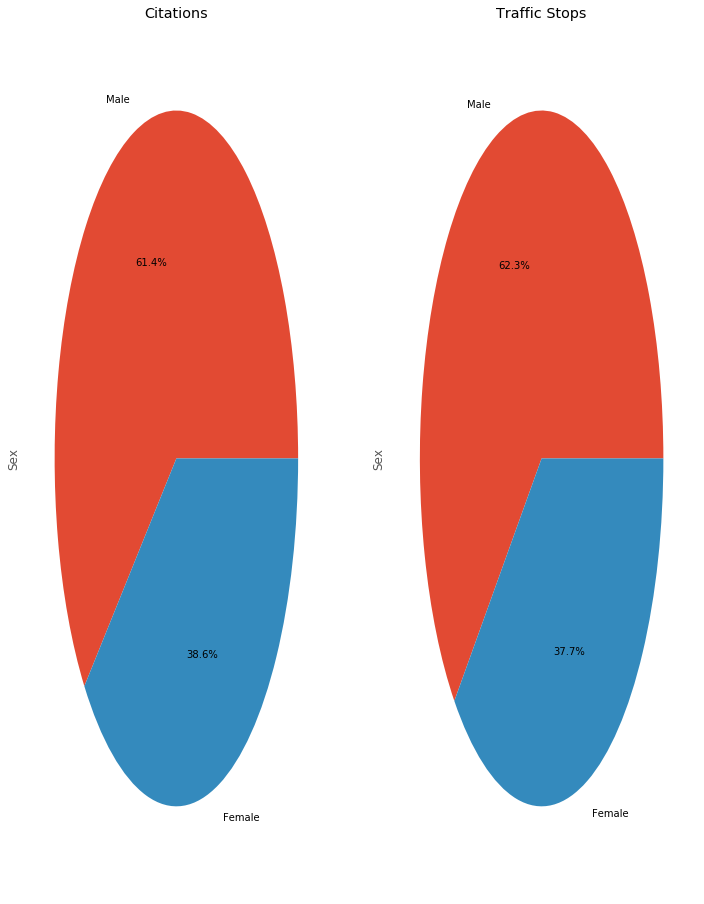

In [23]:
with plt.style.context('ggplot'):
    fig = plt.figure( figsize = (12,16))
    ax1 = fig.add_subplot(1, 2, 1)
    citations_df['Sex'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax1, title = 'Citations')
    
    ax2 = fig.add_subplot(1,2, 2)
    stops_df['Sex'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax2, title = 'Traffic Stops')
    

# 4. Race

In [24]:
print(citations_df['Race'].unique())
print(stops_df['Race'].unique())

['White' 'Asian' 'Black' nan 'Unknown' 'Hispanic']
['White' 'Black' 'Asian' nan 'Hispanic' 'Unknown']


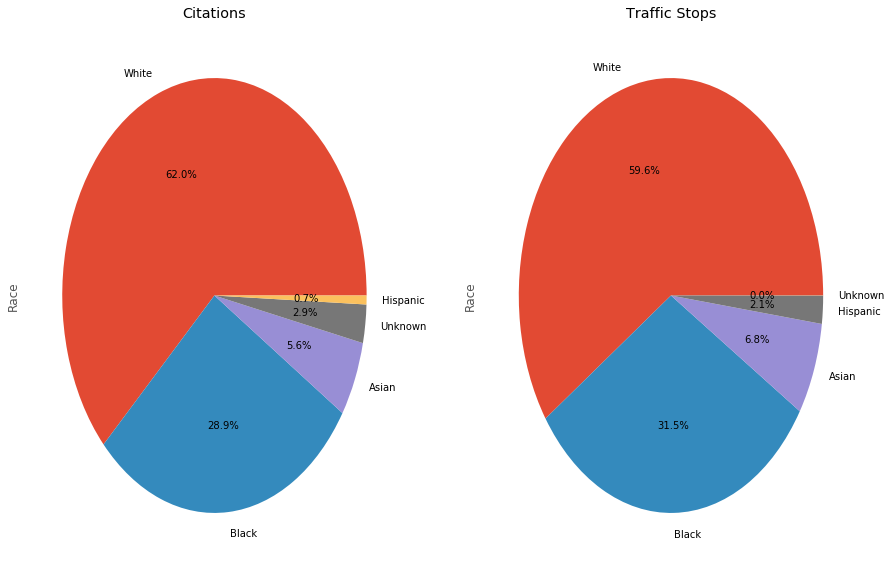

In [25]:
with plt.style.context('ggplot'):
    fig = plt.figure(figsize = (15,10))
    ax1 = fig.add_subplot(1,2,1)
    citations_df['Race'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax1, title = 'Citations')
    
    ax2 = fig.add_subplot(1,2,2)
    stops_df['Race'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax2, title = 'Traffic Stops')

# 5. Age

In [26]:
# Citations
citations_df['Age'].describe()

# Traffic Stops

count    24765.000000
mean        39.454876
std         15.413025
min          0.000000
25%         27.000000
50%         37.000000
75%         51.000000
max         94.000000
Name: Age, dtype: float64

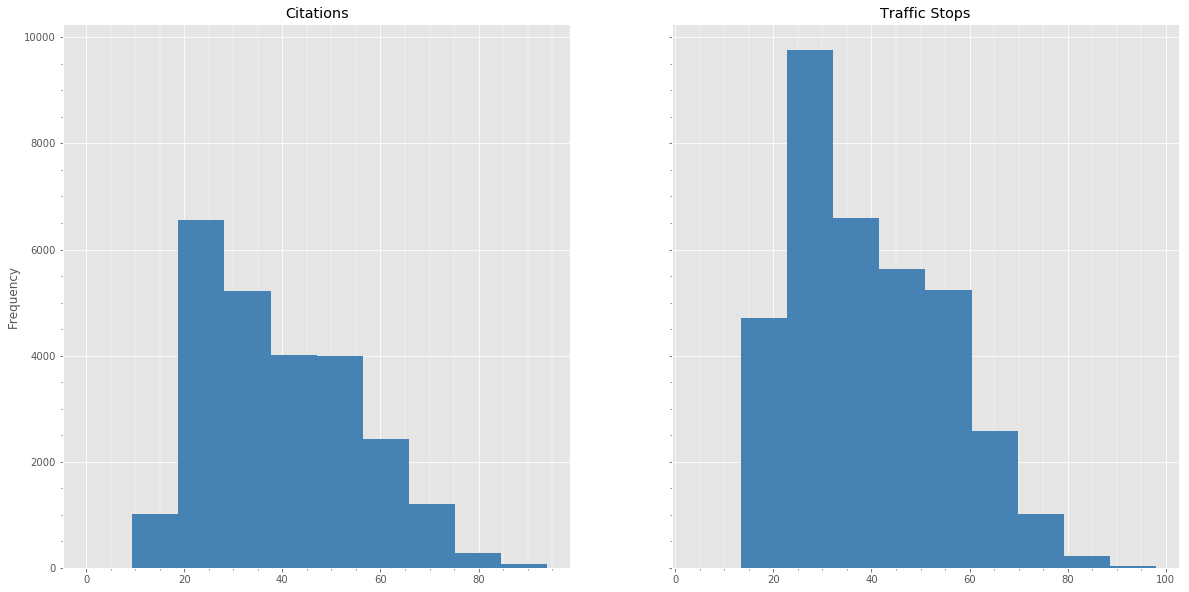

In [27]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize = (20,10), ncols = 2, nrows = 1, sharey = True)
    
    citations_df['Age'].plot(kind = 'hist', ax  = axes[0], title = 'Citations', color = 'steelblue')
    axes[0].minorticks_on()
    axes[0].xaxis.grid(b=True, which='minor', color='w', linewidth = 0.4)
    
    stops_df['Age'].plot(kind = 'hist', ax = axes[1], title = 'Traffic Stops', color = 'steelblue')
    axes[1].minorticks_on()
    axes[1].xaxis.grid(b=True, which='minor', color='w', linewidth = 0.4)
    

# 6. Special Days
## 6.1 Valentine's Day

In [28]:
df_names = ['Citations', 'Traffic Stops']
dates = ['02/14/2017 12:00:00 AM', '02/14/2018 12:00:00 AM', '02/14/2019 12:00:00 AM']
years = ['2017', '2018', '2019']

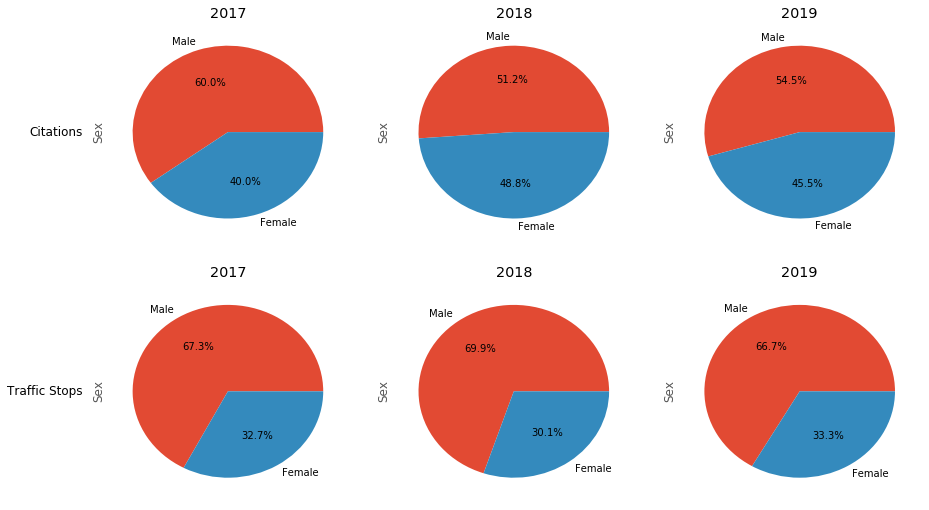

In [29]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize=(15,8), nrows = 2, ncols = 3)
    
    for ax, name in zip(axes[:,0], df_names):
        ax.annotate(name, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
    for ax, this_date, this_year in zip(axes[0,:], dates, years):
        citations_df.loc[citations_df['Citation Date'] == this_date ,:]['Sex'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax, title = this_year)
        
    for ax, this_date, this_year in zip(axes[1,:], dates, years):
        stops_df.loc[stops_df['Stop Date'] == this_date ,:]['Sex'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax, title = this_year)
    
    fig.subplots_adjust(left=0.15, top=0.95)
    

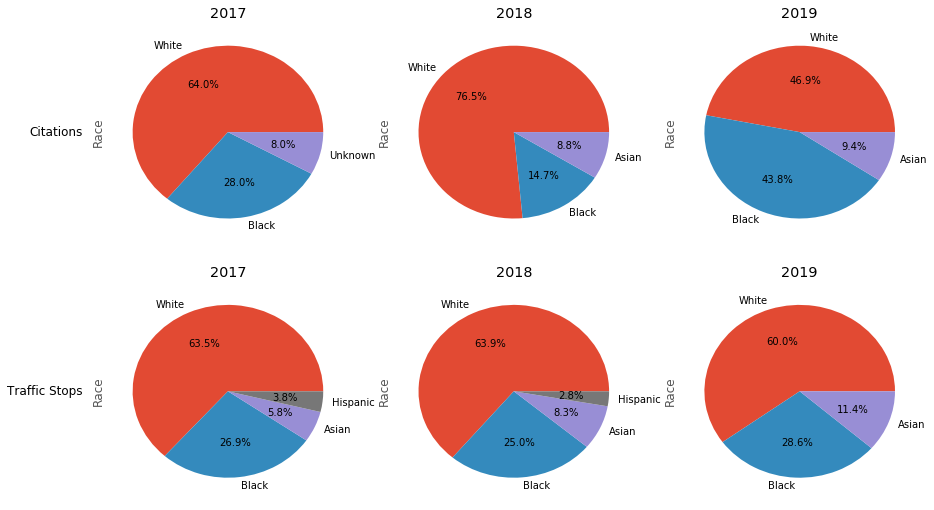

In [30]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize=(15,8), nrows = 2, ncols = 3)
    
    for ax, name in zip(axes[:,0], df_names):
        ax.annotate(name, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
    for ax, this_date, this_year in zip(axes[0,:], dates, years):
        citations_df.loc[citations_df['Citation Date'] == this_date ,:]['Race'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax, title = this_year)
        
    for ax, this_date, this_year in zip(axes[1,:], dates, years):
        stops_df.loc[stops_df['Stop Date'] == this_date ,:]['Race'].value_counts().plot(kind = 'pie', autopct = '%.1f%%', ax = ax, title = this_year)
    
    fig.subplots_adjust(left=0.15, top=0.95)
    

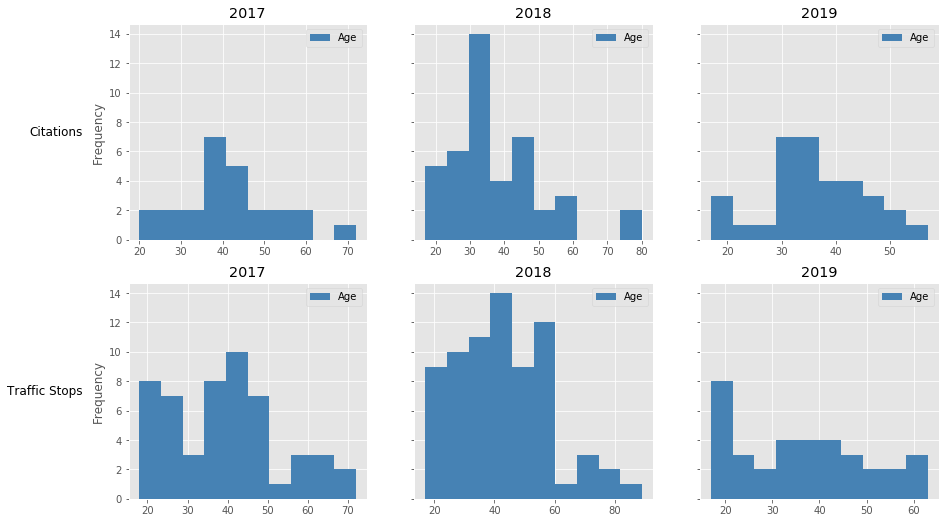

In [31]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize=(15,8), nrows = 2, ncols = 3, sharey = True)
    
    for ax, name in zip(axes[:,0], df_names):
        ax.annotate(name, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
    for ax, this_date, this_year in zip(axes[0,:], dates, years):
        citations_df.loc[citations_df['Citation Date'] == this_date ,['Age']].plot(kind = 'hist', ax = ax, title = this_year, color = 'steelblue')
        
    for ax, this_date, this_year in zip(axes[1,:], dates, years):
        stops_df.loc[stops_df['Stop Date'] == this_date ,['Age']].plot(kind = 'hist', ax = ax, title = this_year, color = 'steelblue')
    
    fig.subplots_adjust(left=0.15, top=0.95)
    

## 6.2 Halloween 

In [32]:
df_names = ['Citations', 'Traffic Stops']
dates = ['10/31/2016 12:00:00 AM', '10/31/2017 12:00:00 AM', '10/31/2018 12:00:00 AM']
years = ['2016', '2017', '2018']

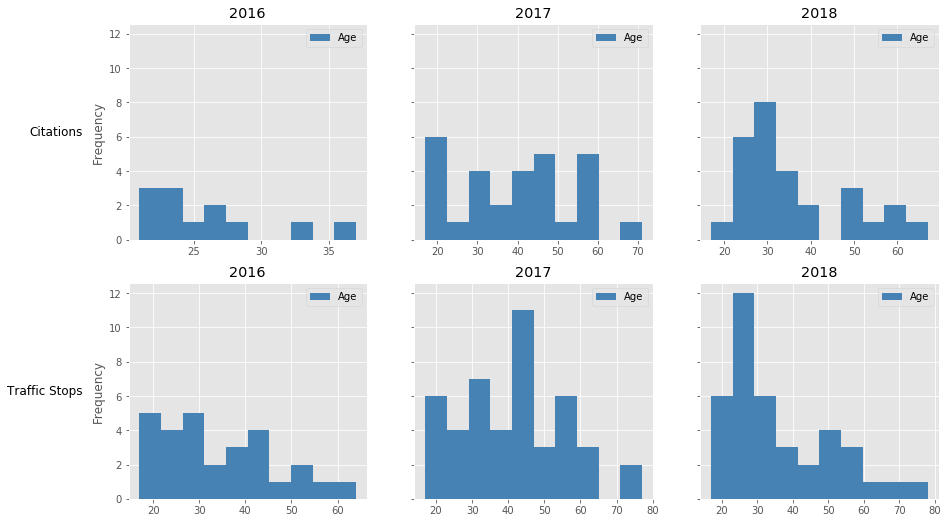

In [33]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(figsize=(15,8), nrows = 2, ncols = 3, sharey = True)
    
    for ax, name in zip(axes[:,0], df_names):
        ax.annotate(name, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
    for ax, this_date, this_year in zip(axes[0,:], dates, years):
        citations_df.loc[citations_df['Citation Date'] == this_date ,['Age']].plot(kind = 'hist', ax = ax, title = this_year, color = 'steelblue')
        
    for ax, this_date, this_year in zip(axes[1,:], dates, years):
        stops_df.loc[stops_df['Stop Date'] == this_date ,['Age']].plot(kind = 'hist', ax = ax, title = this_year, color = 'steelblue')
    
    fig.subplots_adjust(left=0.15, top=0.95)
    

1) Age over weekend vs. weekdays (Day of week)
2) Number of total citations over the years over Christmas
3) Number of total citations over the years over Halloween, Saint Patrick Day's, Thanksgiving, 4th of July, Labor Day
4) Gender over Mother's Day and Father's Day
5) Race over 'Cinco de Mayo'

# 7. Spatial Distribution

In [34]:
import geopy
import re
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='moeinhosseini')
location = geolocator.geocode("500, CHICAGO AV,SOUTH BL, evanston")
print(location.latitude)
print(location.longitude)
re.sub('\/',',',"500, CHICAGO AV/SOUTH BL, evanston")

GeocoderQuotaExceeded: HTTP Error 429: Too Many Requests

In [34]:
#how much geographical location missing data exists in the arrests_df
lat_lon_missing_list = list(np.where(arrests_df['Location'].isnull())[0])
print(len(lat_lon_missing_list))
lat_lon_missing_list = list(np.where(arrests_df['Street Number'].isnull())[0])
print(len(lat_lon_missing_list))
lat_lon_missing_list = list(np.where(arrests_df['Street Name'].isnull())[0])
print(len(lat_lon_missing_list))
lat_lon_missing_list = list(np.where(arrests_df['City'].isnull())[0])
print(len(lat_lon_missing_list))
#Replace the missing data of the city with the name Evanston
arrests_df.iloc[lat_lon_missing_list,13] = 'EVANSTON'


#how much geographical location missing data exists in the activity_df
lat_lon_missing_list = list(np.where(activity_df['Location'].isnull())[0])
print(len(lat_lon_missing_list))
lat_lon_missing_list = list(np.where(activity_df['Block Address'].isnull())[0])
print(len(lat_lon_missing_list))


78
17
0
11
21308
21308


## 7.1 Traffic Stops 

In [35]:
stops_df['Address'] = ''
stops_df.head(5)


,rpmainid,Stop Date,Stop Time,Day of the Week,Age,Race,Sex,Street Number,Street Name,Police Beat,Minute,Hour,Address
0,45963,03/23/2019 12:00:00 AM,20,Sat,22.0,White,Female,800,LINCOLN ST,76.0,20,0,
1,45953,03/22/2019 12:00:00 AM,1800,Fri,67.0,White,Female,500,CHICAGO AV/SOUTH BL,72.0,0,18,
2,45954,03/22/2019 12:00:00 AM,1752,Fri,38.0,White,Male,800,RIDGE AV/WASHINGTON ST,71.0,52,17,
3,45924,03/22/2019 12:00:00 AM,1048,Fri,19.0,Black,Male,900,MULFORD ST/RIDGE AV,78.0,48,10,
4,45915,03/22/2019 12:00:00 AM,1036,Fri,67.0,Black,Male,100,BARTON AV/HOWARD ST,78.0,36,10,


In [ ]:
# import geopy
# import time
# import re
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
# geolocator = Nominatim(user_agent='moeinhosseini')
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# for i in range(len(stops_df)):
#     location_string = str(stops_df.iloc[i,7]) + " " + re.sub('\/.+','',str(stops_df.iloc[i,8])) + ", Evanston"
#     #time.sleep(.1)
#     try:
#         location = geolocator.geocode(location_string, timeout=10)
#         stops_df.iloc[i,12] = location.latitude
#         stops_df.iloc[i,13] = location.longitude
#     except:
#         print("the row number "+str(i)+" with the address: "+location_string+". could not be found on the map")

In [ ]:
# geolocator = Nominatim(user_agent="specify_your_app_name_here")

# from geopy.extra.rate_limiter import RateLimiter
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# df['Coord'] = df['Address'].apply(geocode).apply(lambda location: (location.latitude, location.longitude))
# df.head()

In [46]:
import geopy
import time
import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent='moeinhosseini')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
stops_df['Address'] = ''
for i in range(len(stops_df)):
    location_string = str(stops_df.iloc[i,7]) + " " + re.sub('\/.+','',str(stops_df.iloc[i,8])) + ", Evanston"
    stops_df.iloc[i,10] = location_string
stops_df['Coord'] = stops_df['Address'].apply(geocode).apply(lambda location: (location.latitude, location.longitude))
# for i in range(len(stops_df)):
#     location_string = str(stops_df.iloc[i,7]) + " " + re.sub('\/.+','',str(stops_df.iloc[i,8])) + ", Evanston"
#     #time.sleep(.1)
#     try:
#         location = geolocator.geocode(location_string, timeout=10)
#         stops_df.iloc[i,12] = location.latitude
#         stops_df.iloc[i,13] = location.longitude
#     except:
#         print("the row number "+str(i)+" with the address: "+location_string+". could not be found on the map")

NameError: name 'df' is not defined

In [39]:
#temp = stops_df.iloc[0:100,:]
len(temp)
temp.head(5)

,rpmainid,Stop Date,Stop Time,Day of the Week,Age,Race,Sex,Street Number,Street Name,Police Beat,Minute,Hour,Address
0,45963,03/23/2019 12:00:00 AM,20,Sat,22.0,White,Female,800,LINCOLN ST,76.0,"800 LINCOLN ST, Evanston",0,
1,45953,03/22/2019 12:00:00 AM,1800,Fri,67.0,White,Female,500,CHICAGO AV/SOUTH BL,72.0,"500 CHICAGO AV, Evanston",18,
2,45954,03/22/2019 12:00:00 AM,1752,Fri,38.0,White,Male,800,RIDGE AV/WASHINGTON ST,71.0,"800 RIDGE AV, Evanston",17,
3,45924,03/22/2019 12:00:00 AM,1048,Fri,19.0,Black,Male,900,MULFORD ST/RIDGE AV,78.0,"900 MULFORD ST, Evanston",10,
4,45915,03/22/2019 12:00:00 AM,1036,Fri,67.0,Black,Male,100,BARTON AV/HOWARD ST,78.0,"100 BARTON AV, Evanston",10,


In [ ]:
import geopy
import time
import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent='moeinhosseini')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
temp['Address'] = ''
for i in range(len(temp)):
    location_string = str(temp.iloc[i,7]) + " " + re.sub('\/.+','',str(temp.iloc[i,8])) + ", Evanston"
    temp.iloc[i,10] = location_string
temp['Coord'] = temp['Address'].apply(geocode).apply(lambda location: (location.latitude, location.longitude))
# for i in range(len(stops_df)):
#     location_string = str(stops_df.iloc[i,7]) + " " + re.sub('\/.+','',str(stops_df.iloc[i,8])) + ", Evanston"
#     #time.sleep(.1)
#     try:
#         location = geolocator.geocode(location_string, timeout=10)
#         stops_df.iloc[i,12] = location.latitude
#         stops_df.iloc[i,13] = location.longitude
#     except:
#         print("the row number "+str(i)+" with the address: "+location_string+". could not be found on the map")

C:\Users\Moein\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Moein\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein

RateLimiter swallowed an error after 2 retries. Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurred:


RateLimiter caught an error, retrying (1/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (1/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (1/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (1/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

RateLimiter caught an error, retrying (0/2 tries). Called with (*('',), **{}).
Traceback (most recent call last):
  File "C:\Users\Moein\Anaconda3\lib\site-packages\geopy\geocoders\base.py", line 344, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 532, in open
    response = meth(req, response)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 642, in http_response
    'http', request, response, code, msg, hdrs)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 570, in error
    return self._call_chain(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 504, in _call_chain
    result = func(*args)
  File "C:\Users\Moein\Anaconda3\lib\urllib\request.py", line 650, in http_error_default
    raise HTTPError(req.full_url, code, msg, hdrs, fp)
urllib.error.HTTPError: HTTP Error 429: Too Many Requests

During handling of the above exception, another exception occurre

In [52]:
# import gmplot package 
import gmplot 

latitude_list = arrests_df['Location'].str.extract('\((.+),')
latitude_list = latitude_list.iloc[:,0].astype(float).fillna(0.0)
longitude_list = arrests_df['Location'].str.extract(', (.+)\)')
longitude_list = longitude_list.iloc[:,0].astype(float).fillna(0.0) 
gmap = gmplot.GoogleMapPlotter(42.0451,-87.6877,13) 
# heatmap plot heating Type 
# points on the Google map 
#gmap.heatmap( latitude_list, longitude_list, threshold=1, radius=100, gradient=None, opacity=0.5, dissipating=True) 
#gmap.heatmap( latitude_list, longitude_list)
gmap.scatter( latitude_list, longitude_list, '# FF0000', size = 40, marker = False )
gmap.draw( "map_arrests.html" )

IndexingError: Too many indexers

In [90]:
# import gmplot package 
import gmplot 
start_time = pd.to_datetime('09/19/2017 12:00:00 AM', format = '%m/%d/%Y %H:%M:%S %p')
end_time = pd.to_datetime('09/27/2018 12:00:00 AM', format = '%m/%d/%Y %H:%M:%S %p')
activity_2017_2018_df = activity_df[activity_df['DateTime_Object']>start_time]
activity_2017_2018_df = activity_2017_2018_df[activity_2017_2018_df['DateTime_Object']<end_time]

latitude_list = activity_2017_2018_df['Location'].str.extract('\((.+),')
longitude_list = activity_2017_2018_df['Location'].str.extract(', (.+)\)')

lat_missing_list = list(np.where(latitude_list.isnull())[0])
latitude_list = latitude_list.drop(latitude_list.index[lat_missing_list])
longitude_list = longitude_list.drop(longitude_list.index[lat_missing_list])
lon_missing_list = list(np.where(longitude_list.isnull())[0])
latitude_list = latitude_list.drop(latitude_list.index[lon_missing_list])
longitude_list = longitude_list.drop(longitude_list.index[lon_missing_list])

latitude_list = latitude_list.astype(float)
longitude_list = longitude_list.astype(float)
print(len(latitude_list))
print(len(longitude_list))

gmap = gmplot.GoogleMapPlotter(42.0451,-87.6877,13) 
gmap.scatter( latitude_list, longitude_list, '# FF0000', size = 40, marker = False )
gmap.draw( "map_activity.html" )

75684
75684


## 7.1 Fall Examination 2017-2018 

In [92]:
# import gmplot package 
import gmplot 
start_time = pd.to_datetime('12/04/2017 12:00:00 AM', format = '%m/%d/%Y %H:%M:%S %p')
end_time = pd.to_datetime('12/09/2017 12:00:00 AM', format = '%m/%d/%Y %H:%M:%S %p')
activity_2017_2018_df = activity_df[activity_df['DateTime_Object']>start_time]
activity_2017_2018_df = activity_2017_2018_df[activity_2017_2018_df['DateTime_Object']<end_time]

latitude_list = activity_2017_2018_df['Location'].str.extract('\((.+),')
longitude_list = activity_2017_2018_df['Location'].str.extract(', (.+)\)')

lat_missing_list = list(np.where(latitude_list.isnull())[0])
latitude_list = latitude_list.drop(latitude_list.index[lat_missing_list])
longitude_list = longitude_list.drop(longitude_list.index[lat_missing_list])
lon_missing_list = list(np.where(longitude_list.isnull())[0])
latitude_list = latitude_list.drop(latitude_list.index[lon_missing_list])
longitude_list = longitude_list.drop(longitude_list.index[lon_missing_list])

latitude_list = latitude_list.astype(float)
longitude_list = longitude_list.astype(float)
print(len(latitude_list))
print(len(longitude_list))

gmap = gmplot.GoogleMapPlotter(42.0451,-87.6877,13) 
gmap.scatter( latitude_list, longitude_list, '# FF0000', size = 40, marker = False )
gmap.draw( "map_activity_exam_fall.html" )

905
905


## 7.2 Winter Examination 2017-2018 

In [95]:
# import gmplot package 
import gmplot 
start_time = pd.to_datetime('03/19/2018 12:00:00 AM', format = '%m/%d/%Y %H:%M:%S %p')
end_time = pd.to_datetime('03/24/2018 12:00:00 AM', format = '%m/%d/%Y %H:%M:%S %p')
activity_2017_2018_df = activity_df[activity_df['DateTime_Object']>start_time]
activity_2017_2018_df = activity_2017_2018_df[activity_2017_2018_df['DateTime_Object']<end_time]

latitude_list = activity_2017_2018_df['Location'].str.extract('\((.+),')
longitude_list = activity_2017_2018_df['Location'].str.extract(', (.+)\)')

lat_missing_list = list(np.where(latitude_list.isnull())[0])
latitude_list = latitude_list.drop(latitude_list.index[lat_missing_list])
longitude_list = longitude_list.drop(longitude_list.index[lat_missing_list])
lon_missing_list = list(np.where(longitude_list.isnull())[0])
latitude_list = latitude_list.drop(latitude_list.index[lon_missing_list])
longitude_list = longitude_list.drop(longitude_list.index[lon_missing_list])

latitude_list = latitude_list.astype(float)
longitude_list = longitude_list.astype(float)
print(len(latitude_list))
print(len(longitude_list))

gmap = gmplot.GoogleMapPlotter(42.0451,-87.6877,13) 
gmap.scatter( latitude_list, longitude_list, '# FF0000', size = 40, marker = False )
gmap.draw( "map_activity_exam_winter.html" )

1100
1100


## 7.3 Spring Examination 2017-2018 

In [96]:
# import gmplot package 
import gmplot 
start_time = pd.to_datetime('06/11/2018 12:00:00 AM', format = '%m/%d/%Y %H:%M:%S %p')
end_time = pd.to_datetime('06/16/2018 12:00:00 AM', format = '%m/%d/%Y %H:%M:%S %p')
activity_2017_2018_df = activity_df[activity_df['DateTime_Object']>start_time]
activity_2017_2018_df = activity_2017_2018_df[activity_2017_2018_df['DateTime_Object']<end_time]

latitude_list = activity_2017_2018_df['Location'].str.extract('\((.+),')
longitude_list = activity_2017_2018_df['Location'].str.extract(', (.+)\)')

lat_missing_list = list(np.where(latitude_list.isnull())[0])
latitude_list = latitude_list.drop(latitude_list.index[lat_missing_list])
longitude_list = longitude_list.drop(longitude_list.index[lat_missing_list])
lon_missing_list = list(np.where(longitude_list.isnull())[0])
latitude_list = latitude_list.drop(latitude_list.index[lon_missing_list])
longitude_list = longitude_list.drop(longitude_list.index[lon_missing_list])

latitude_list = latitude_list.astype(float)
longitude_list = longitude_list.astype(float)
print(len(latitude_list))
print(len(longitude_list))

gmap = gmplot.GoogleMapPlotter(42.0451,-87.6877,13) 
gmap.scatter( latitude_list, longitude_list, '# FF0000', size = 40, marker = False )
gmap.draw( "map_activity_exam_spring.html" )

1083
1083
